# ML for Causal Inference: High-Dimensional Instruments

In [15]:
library(glmnet)
library(stats)
library(ggplot2)
library(AER)

## Example: Weak First Stage and Exclusion Restriction Violation

In [3]:
#Simulate Data
set.seed(1)
N <- 1e3 # Number of Observations
# Simulate Data for Example in Intro
weak <- rnorm(n = N)
good <- rnorm(n = N)
correl <- rnorm(n = N) 
C <- 3 * correl + rnorm(n = N)
X <- -.000001 * round(weak) + 2.5 * correl + 2.5 * good + .5 * C + rnorm(n = N)
Y <- 2.0 * X + 1.1 * C + rnorm(n = N)
df <- cbind(Y, X, correl, good, weak)
colnames(df) <- c('Y', 'X', 'correl', 'good', 'weak')
df <- data.frame(df)

In [4]:
# No Instrument, naive regression
fit.none <- lm(Y ~ X, data = df)
summary(fit.none)
X.none <- fit.none$coefficients[2]
ci.none <- confint(fit.none, 'X', level = 0.95)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3707 -1.3519  0.0967  1.4833  7.1721 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.05197    0.07199   0.722    0.471    
X            2.59080    0.01440 179.964   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.276 on 998 degrees of freedom
Multiple R-squared:  0.9701,	Adjusted R-squared:  0.9701 
F-statistic: 3.239e+04 on 1 and 998 DF,  p-value: < 2.2e-16


In [5]:
# Fit using a good instrument (strong first stage and satisfies exclusion restriction)
fit.good <- ivreg(Y ~ X | good, data = df)
summary(fit.good, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.good <- fit.good$coefficients[2]
ci.good <- confint(fit.good, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | good, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-12.17673  -2.46209  -0.01462   2.48840   9.03775 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.05682    0.11246   0.505    0.613    
X            2.04400    0.04075  50.155   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998     435.1  <2e-16 ***
Wu-Hausman         1 997    1575.1  <2e-16 ***
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.56 on Inf degrees of freedom
Multiple R-Squared: 0.9269,	Adjusted R-squared: 0.9268 
Wald test:  2516 on 1 DF,  p-value: < 2.2e-16 


In [6]:
# Fit using a weak instrument (satisfies exclusion restriction)
fit.weak <- ivreg(Y ~ X | weak, data = df)
summary(fit.weak, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.weak <- fit.weak$coefficients[2]
ci.weak <- confint(fit.weak, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | weak, data = df)

Residuals:
       Min         1Q     Median         3Q        Max 
-10.124204  -1.801685   0.004844   1.857427   9.091541 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.04916    0.08775   0.560    0.575    
X            2.90671    0.47201   6.158 7.36e-10 ***

Diagnostic tests:
                 df1 df2 statistic p-value
Weak instruments   1 998     1.520   0.218
Wu-Hausman         1 997     0.698   0.404
Sargan             0  NA        NA      NA

Residual standard error: 2.772 on Inf degrees of freedom
Multiple R-Squared: 0.9557,	Adjusted R-squared: 0.9556 
Wald test: 37.92 on 1 DF,  p-value: 7.363e-10 


In [7]:
# Fit using an instrument that doesn't satisfy the exclusion restriction (but with a strong first stage)
fit.correl <- ivreg(Y ~ X | correl, data = df)
summary(fit.correl, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.correl <- fit.correl$coefficients[2]
ci.correl <- confint(fit.correl, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | correl, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-9.51414 -1.64965 -0.05292  1.71357  8.66626 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.04978    0.08177   0.609    0.543    
X            2.83672    0.01954 145.181   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998      2201  <2e-16 ***
Wu-Hausman         1 997      1593  <2e-16 ***
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.588 on Inf degrees of freedom
Multiple R-Squared: 0.9614,	Adjusted R-squared: 0.9613 
Wald test: 2.108e+04 on 1 DF,  p-value: < 2.2e-16 


Warning message in data.row.names(row.names, rowsi, i):
"some row.names duplicated: 3,4,5 --> row.names NOT used"Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

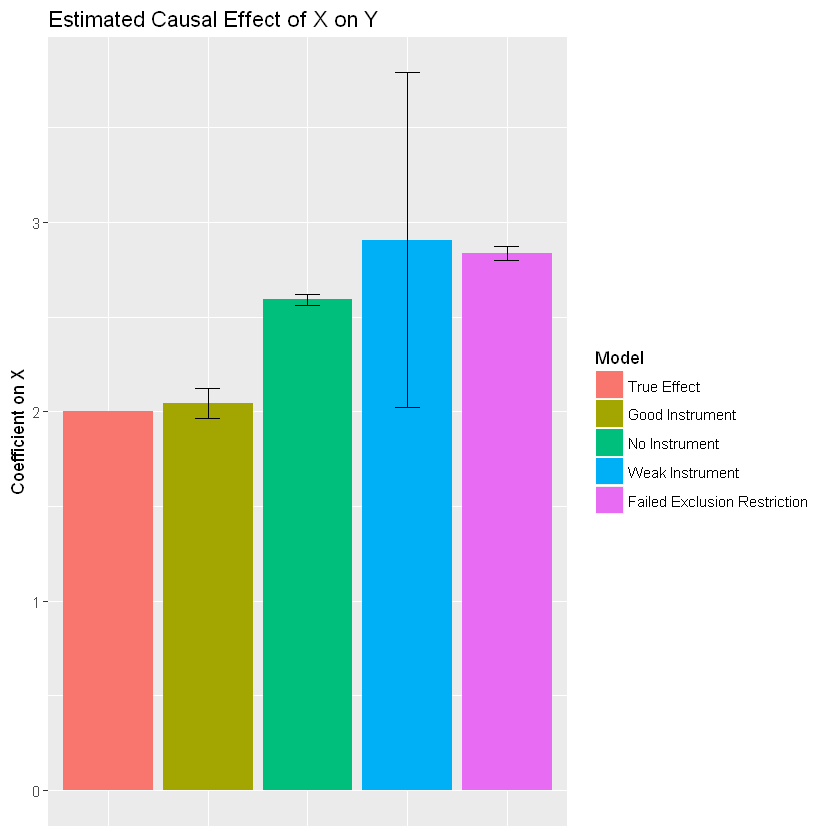

In [8]:
# Vector of T coefficients and confidence intervals
coefs.ab <- c(2.0, X.good, X.none, X.weak, X.correl)
ci.low <- c(NaN, ci.good[1], ci.none[1], ci.weak[1], ci.correl[1])
ci.high <- c(NaN, ci.good[2], ci.none[2], ci.weak[2], ci.correl[2])
dat <- cbind(coefs.ab, ci.low, ci.high, c('True Effect', 'Good Instrument', 'No Instrument', 'Weak Instrument', 'Failed Exclusion Restriction'))
colnames(dat)[4] <- 'Model'
dat <- data.frame(dat)
dat$coefs.ab <- as.double(levels(dat$coefs.ab))[dat$coefs.ab]
dat$ci.low <- as.double(levels(dat$ci.low))[dat$ci.low]
dat$ci.high <- as.double(levels(dat$ci.high))[dat$ci.high]
dat$Model <- factor(dat$Model, levels = dat$Model)

# Create bar graph
dodge <- position_dodge(width = 0.9)
limits <- aes(ymax = dat$ci.high,
              ymin = dat$ci.low)
p <- ggplot(data = dat, aes(x = Model, y = coefs.ab, fill = Model))
p + geom_bar(stat = "identity", position = dodge) +
  geom_errorbar(limits, position = dodge, width = 0.25) +
    ylab("Coefficient on X") +
    ggtitle("Estimated Causal Effect of X on Y") +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

# LASSO for Instrument Selection

In [9]:
rm(list=ls())
invisible(gc()) # Clear workspace
#Simulate Data
set.seed(1)
N <- 1e3 # Number of Observations
p <- N + 30 # Number of instruments (excluding unobservable)
# Generate matrix M of p randomly assigned AB tests
M <- matrix(0, N, p)
M[0:(N/2),] <- 1
M <- apply(t(M), 1, function(d) sample(d, N))
# Create an unobservable C
C <- rnorm(n = N)
# Create X as a function of weak instruments, good instruments, instruments that don't satisfy the exclusion restriction, and C
beta.X <- rnorm(p, mean = 1, sd = 3) * sign(rnorm(n = p))
beta.X[1:20] <- rnorm(20, mean = 1, sd = 3)
beta.X[21] <- 8
beta.X[201:p] <- 0
X <- M %*% beta.X + 1 * C + rnorm(n = N)
# Create Y as a function of X, C, and other variables that affect X
beta.Y <- rnorm(20, mean = 5, sd = 3) * sign(rnorm(n = 20))
Y <- 2.0 * X + 80 * C + rnorm(n = N) + M[, 1:20] %*% beta.Y
# Create data frames with and without variables that don't satisfy the exclusion restriction
colnames(M) <- colnames(data.frame('M' = M))
M.excl <- M[, 21:p]
df.allM <- data.frame('Y' = Y, 'X' = X, M)
df.excl <- data.frame('Y' = Y, 'X' = X, M.excl)

## LASSO X on M

In [10]:
lasso.fit <- cv.glmnet(M.excl, df.excl$X, alpha=1)
coef <- predict(lasso.fit, type = "nonzero")
M.excl.names <- colnames(M.excl)
Z <- M.excl.names[unlist(coef)]
# Instruments selected by LASSO:
Z

[1] "M.21"   "M.22"   "M.24"   "M.27"   "M.28"   "M.29"   "M.31"   "M.32"  
  [9] "M.33"   "M.34"   "M.36"   "M.37"   "M.38"   "M.39"   "M.42"   "M.44"  
 [17] "M.48"   "M.49"   "M.50"   "M.51"   "M.52"   "M.56"   "M.57"   "M.58"  
 [25] "M.59"   "M.60"   "M.61"   "M.64"   "M.65"   "M.66"   "M.72"   "M.74"  
 [33] "M.75"   "M.77"   "M.78"   "M.80"   "M.81"   "M.83"   "M.86"   "M.88"  
 [41] "M.89"   "M.90"   "M.92"   "M.94"   "M.95"   "M.96"   "M.97"   "M.99"  
 [49] "M.100"  "M.102"  "M.103"  "M.104"  "M.105"  "M.108"  "M.109"  "M.113" 
 [57] "M.114"  "M.115"  "M.116"  "M.117"  "M.118"  "M.119"  "M.120"  "M.121" 
 [65] "M.122"  "M.123"  "M.124"  "M.125"  "M.128"  "M.129"  "M.132"  "M.134" 
 [73] "M.136"  "M.137"  "M.138"  "M.139"  "M.141"  "M.142"  "M.147"  "M.149" 
 [81] "M.150"  "M.151"  "M.153"  "M.154"  "M.155"  "M.156"  "M.158"  "M.159" 
 [89] "M.160"  "M.162"  "M.163"  "M.164"  "M.165"  "M.168"  "M.169"  "M.170" 
 [97] "M.171"  "M.173"  "M.174"  "M.175"  "M.176"  "M.177"  "M.178"  "M.180" 
[105] "M.181"  "M.182"  "M.183"  "M.185"  "M.186"  "M.187"  "M.188"  "M.189" 
[113] "M.190"  "M.191"  "M.192"  "M.193"  "M.194"  "M.196"  "M.197"  "M.198" 
[121] "M.199"  "M.200"  "M.205"  "M.210"  "M.218"  "M.221"  "M.227"  "M.237" 
[129] "M.252"  "M.255"  "M.260"  "M.262"  "M.281"  "M.282"  "M.291"  "M.292" 
[137] "M.300"  "M.303"  "M.318"  "M.319"  "M.321"  "M.324"  "M.332"  "M.342" 
[145] "M.343"  "M.358"  "M.370"  "M.371"  "M.377"  "M.386"  "M.391"  "M.393" 
[153] "M.400"  "M.402"  "M.414"  "M.418"  "M.422"  "M.431"  "M.436"  "M.437" 
[161] "M.442"  "M.443"  "M.444"  "M.445"  "M.452"  "M.453"  "M.467"  "M.478" 
[169] "M.479"  "M.493"  "M.495"  "M.497"  "M.500"  "M.504"  "M.506"  "M.508" 
[177] "M.514"  "M.515"  "M.523"  "M.535"  "M.543"  "M.544"  "M.546"  "M.556" 
[185] "M.561"  "M.573"  "M.575"  "M.584"  "M.585"  "M.606"  "M.607"  "M.614" 
[193] "M.617"  "M.619"  "M.647"  "M.651"  "M.655"  "M.659"  "M.662"  "M.668" 
[201] "M.670"  "M.679"  "M.687"  "M.691"  "M.697"  "M.701"  "M.717"  "M.729" 
[209] "M.731"  "M.732"  "M.741"  "M.744"  "M.745"  "M.754"  "M.800"  "M.807" 
[217] "M.810"  "M.820"  "M.821"  "M.825"  "M.832"  "M.833"  "M.835"  "M.842" 
[225] "M.843"  "M.850"  "M.862"  "M.863"  "M.876"  "M.879"  "M.886"  "M.897" 
[233] "M.899"  "M.907"  "M.914"  "M.915"  "M.917"  "M.923"  "M.933"  "M.943" 
[241] "M.951"  "M.952"  "M.956"  "M.962"  "M.964"  "M.966"  "M.983"  "M.988" 
[249] "M.996"  "M.997"  "M.998"  "M.1000" "M.1001" "M.1004" "M.1007" "M.1008"
[257] "M.1009" "M.1012" "M.1014" "M.1015" "M.1016" "M.1023" "M.1029"

In [11]:
Z.list <- paste("~ ", paste(Z, collapse = " + "))
fit.lasso.excl <- ivreg(Y ~ X, Z.list, data = df.excl)
summary(fit.lasso.excl, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.lasso.excl <- fit.lasso.excl$coefficients[2]
ci.lasso.excl <- confint(fit.lasso.excl, 'X', level = 0.95, vcov = sandwich)


Call:
ivreg(formula = Y ~ X | M.21 + M.22 + M.24 + M.27 + M.28 + M.29 + 
    M.31 + M.32 + M.33 + M.34 + M.36 + M.37 + M.38 + M.39 + M.42 + 
    M.44 + M.48 + M.49 + M.50 + M.51 + M.52 + M.56 + M.57 + M.58 + 
    M.59 + M.60 + M.61 + M.64 + M.65 + M.66 + M.72 + M.74 + M.75 + 
    M.77 + M.78 + M.80 + M.81 + M.83 + M.86 + M.88 + M.89 + M.90 + 
    M.92 + M.94 + M.95 + M.96 + M.97 + M.99 + M.100 + M.102 + 
    M.103 + M.104 + M.105 + M.108 + M.109 + M.113 + M.114 + M.115 + 
    M.116 + M.117 + M.118 + M.119 + M.120 + M.121 + M.122 + M.123 + 
    M.124 + M.125 + M.128 + M.129 + M.132 + M.134 + M.136 + M.137 + 
    M.138 + M.139 + M.141 + M.142 + M.147 + M.149 + M.150 + M.151 + 
    M.153 + M.154 + M.155 + M.156 + M.158 + M.159 + M.160 + M.162 + 
    M.163 + M.164 + M.165 + M.168 + M.169 + M.170 + M.171 + M.173 + 
    M.174 + M.175 + M.176 + M.177 + M.178 + M.180 + M.181 + M.182 + 
    M.183 + M.185 + M.186 + M.187 + M.188 + M.189 + M.190 + M.191 + 
    M.192 + M.193 + M.194 + M.196 + M.1

In [12]:
# 1st Stage
firststage <- paste("X ~ ", paste(Z, collapse = " + "))
fit.firststage <- lm(firststage, data = df.excl)
summary(fit.firststage)


Call:
lm(formula = firststage, data = df.excl)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.9128  -4.6348   0.0469   4.7421  25.3936 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 16.65727    4.96749   3.353 0.000840 ***
M.21         7.45683    0.59766  12.477  < 2e-16 ***
M.22         3.07880    0.60979   5.049 5.61e-07 ***
M.24         0.18682    0.60042   0.311 0.755780    
M.27        -0.77498    0.61533  -1.259 0.208264    
M.28        -1.61563    0.61389  -2.632 0.008671 ** 
M.29         6.79645    0.59812  11.363  < 2e-16 ***
M.31        -5.10766    0.60638  -8.423  < 2e-16 ***
M.32        -7.99610    0.60722 -13.168  < 2e-16 ***
M.33        -4.21564    0.61033  -6.907 1.07e-11 ***
M.34        -3.61063    0.59850  -6.033 2.55e-09 ***
M.36         3.72336    0.61139   6.090 1.82e-09 ***
M.37         1.75867    0.61362   2.866 0.004275 ** 
M.38         2.43741    0.60922   4.001 6.95e-05 ***
M.39         4.34731    0.61465   7.07

In [13]:
# No instruments
fit.noinst <- lm(Y ~ X, data = df.allM)
X.noinst <- fit.noinst$coefficients[2]
ci.noinst <- confint(fit.noinst, 'X', level = 0.95)

# Lasso, but using all M
lasso.fit.allM <- cv.glmnet(M, df.allM$X, alpha=1)
coef <- predict(lasso.fit.allM, type = "nonzero")
M.names <- colnames(M)
Z.allM <- M.names[unlist(coef)]
Z.allM.list <- paste("~ ", paste(Z.allM, collapse = " + "))
fit.lasso.allM <- ivreg(Y ~ X, Z.allM.list, data = df.allM)
X.lasso.allM <- fit.lasso.allM$coefficients[2]
ci.lasso.allM <- confint(fit.lasso.allM, 'X', level = 0.95, vcov = sandwich)

# All possible IV
M.all.list <- paste("~ ", paste(M.names, collapse = " + "))
fit.allM <- ivreg(Y ~ X, M.all.list, data = df.allM)
X.allM <- fit.allM$coefficients[2]
ci.allM <- confint(fit.allM, 'X', level = 0.95, vcov = sandwich)

# Largest subset of all possible IV
M.largest.list <- paste("~ ", paste(M.names[1:(N-1)], collapse = " + "))
fit.largest <- ivreg(Y ~ X, M.largest.list, data = df.allM)
X.largest <- fit.largest$coefficients[2]
ci.largest <- confint(fit.largest, 'X', level = 0.95, vcov = sandwich)

# Hand picked IV
handpick.list <- paste("~ ", paste(M.names[21:30], collapse = " + "))
fit.handpick <- ivreg(Y ~ X, handpick.list, data = df.allM)
X.handpick <- fit.handpick$coefficients[2]
ci.handpick <- confint(fit.handpick, 'X', level = 0.95, vcov = sandwich)

# Best possible single instrument
fit.bestone <- ivreg(Y ~ X | M.21, data = df.allM)
X.bestone <- fit.bestone$coefficients[2]
ci.bestone <- confint(fit.bestone, 'X', level = 0.95, vcov = sandwich)

Warning message in data.row.names(row.names, rowsi, i):
"some row.names duplicated: 3,4,5,6 --> row.names NOT used"Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

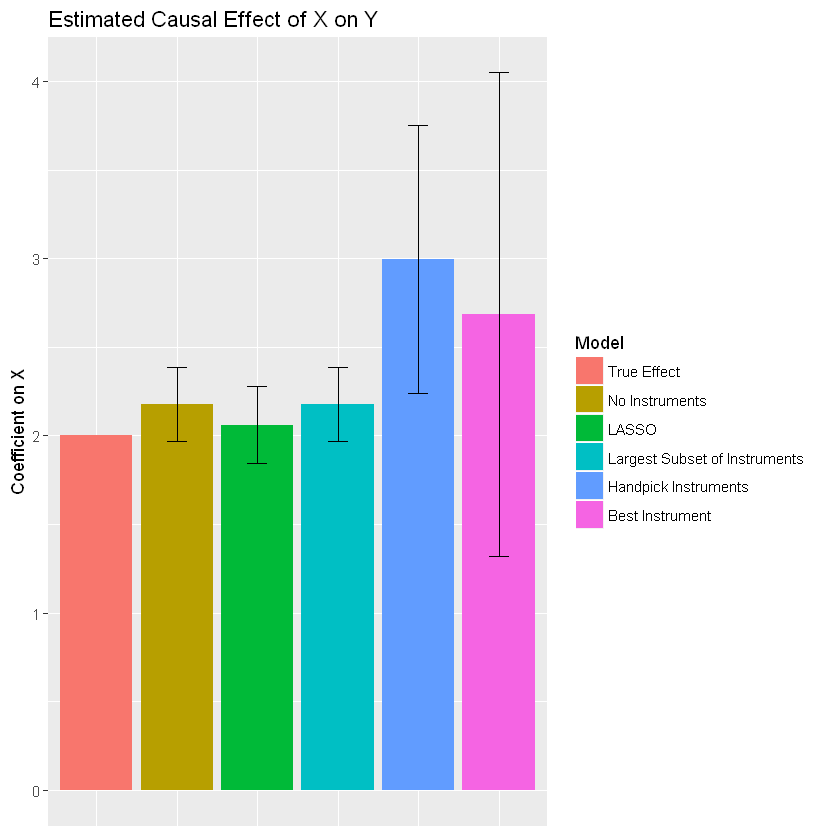

In [14]:
# Vector of T coefficients and confidence intervals
coefs.ab <- c(2.0, X.noinst, X.lasso.excl, X.largest, X.handpick, X.bestone)
ci.low <- c(NaN, ci.noinst[1], ci.lasso.excl[1], ci.largest[1], ci.handpick[1], ci.bestone[1])
ci.high <- c(NaN, ci.noinst[2], ci.lasso.excl[2], ci.largest[2], ci.handpick[2], ci.bestone[2])
dat <- cbind(coefs.ab, ci.low, ci.high, c('True Effect', 'No Instruments', 'LASSO',
                                          'Largest Subset of Instruments', 'Handpick Instruments', 'Best Instrument'))
colnames(dat)[4] <- 'Model'
dat <- data.frame(dat)
dat$coefs.ab <- as.double(levels(dat$coefs.ab))[dat$coefs.ab]
dat$ci.low <- as.double(levels(dat$ci.low))[dat$ci.low]
dat$ci.high <- as.double(levels(dat$ci.high))[dat$ci.high]
dat$Model <- factor(dat$Model, levels = dat$Model)

# Create bar graph
dodge <- position_dodge(width = 0.9)
limits <- aes(ymax = dat$ci.high,
              ymin = dat$ci.low)
p <- ggplot(data = dat, aes(x = Model, y = coefs.ab, fill = Model))
p + geom_bar(stat = "identity", position = dodge) +
  geom_errorbar(limits, position = dodge, width = 0.25) +
    ylab("Coefficient on X") +
    ggtitle("Estimated Causal Effect of X on Y") +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())